In [2]:
import numpy as np
import math
from scipy.optimize import *
import matplotlib.pyplot as plt
import scipy

In [3]:
#in centimeters
from re import X


wavelength = 633*(10**-7)  # in cm

# Use this function to curvefit for power as a function of x to calculate w(z)
# IMPORTANT remmeber power is proportional to voltage measured on the oscilloscope
def power_as_func_of_x(x, amp, x0, waist):
    return (amp/2)*(1 + scipy.special.erf(np.sqrt(2)*(x-x0)/waist))

# Use this function to curvefit for waist as a function of z to calculate w0
# IMPORTANT, the parameters are in cm
def waist_as_func_of_z(z, w0, z0, b):
    return w0*np.sqrt(1+(((z-z0)**2)/(b**2)))

#alternate in terms of b
def waist_as_func_of_z_alt(z, z0, b):
    return b*np.sqrt(1+(((z-z0)**2)/(b**2)))/(np.pi) * wavelength

#calculate q for R and w
def calculate_q(radius_of_curvature,waist):
    return 1/(1/radius_of_curvature - 1j*wavelength/(np.pi*waist*waist))

#calculate w and R from q
def calculate_waist_radius_from_q(q_parameter):
    if(np.real(q_parameter) == 0):
        return [np.sqrt(-1*wavelength/(np.pi*np.imag(1/q_parameter) )),99999999999]
    else:
        return [np.sqrt(-1*wavelength/(np.pi*np.imag(1/q_parameter) )),1/np.real(1/q_parameter)]
# returns output q for input q and abcd
def calculate_q_out(qin, abcd):
    return (abcd[0][0]*qin + abcd[0][1])/(abcd[1][0]*qin + abcd[1][1])

#calculate q from w, R is infiniy
def calculate_q_from_waist(waist):
    return 1j*np.pi*waist*waist/wavelength





# ABCD parameters 
#length in cm
def abcd_free_space(length):
    return [[1,np.float64(length)],[0,1]]

#focal length in cm
def abcd_lens(focal_length):
    return [[1,0],[(-1/np.float64(focal_length)),1]]

#Radius of Curvature in cm, R +ve for concave, -ve for convex mirrors
def abcd_mirror(Roc):
    return [[1,0],[-2/np.float64(Roc), 1]]

#f and length in cm
def abcd_telescope(f_eye, f_obj, length):
    #print(abcd_lens(f_eye)@ abcd_free_space(length)@ abcd_lens(f_obj))
    array =  ((np.array(abcd_lens(np.float64(f_eye)))@ np.array(abcd_free_space(np.float64(length))) @np.array(abcd_lens(np.float64(f_obj)))))
    #print(array)
    return array.tolist()

# abcd for a cavity, all lengths in cm; Roc = 2*f
def abcd_cavity(l_big, l_small, Roc):
    l_diag = np.sqrt((l_big**2) + (l_small**2))
    array  = np.array(abcd_free_space(l_diag)) @ np.array(abcd_free_space(l_big)) @ np.array(abcd_mirror(Roc)) @ np.array(abcd_free_space(l_diag)) @ np.array(abcd_free_space(l_big))
    return array.tolist()


# calculate the resonance q for a SYMMETRIC bowtie cavity given the abcd matrix
def q_resonance_cavity(abcd_cavity):
    A = np.complex64(abcd_cavity[0][0])
    B = np.complex64(abcd_cavity[0][1])
    C = np.complex64(abcd_cavity[1][0])
    D = np.complex64(abcd_cavity[1][1])
    a = C
    b = D-A
    c = -1*B
    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    #return ((a-d)/c + np.sqrt(-1*((d/c-a/c)**2) - 4*b/c))/2


# returns the absolute value of difference of b at the output of telescope and b for cavity, b is inversely proportional to the beam waist
def function_telescope_len_for_cavity(len_tel, f_obj, f_eye, q_in_tel, q_cavity):
    o = f_obj
    e = f_eye
    x = len_tel
    
    A = 1 - (x/o)
    B = x
    C = (-1*(1-(x/e))/o) - 1/e
    D = 1-(x/e)

    q_o_tel = (A*q_in_tel + B)/(C*q_in_tel + D)
    return abs(np.imag(q_o_tel) - np.imag(q_cavity))


# function to return the difference of 'b' at end of two telecopes and 'b' at the cavity. Can be minimized to find the coorect length  
def function_len_between_two_telescopes_for_cavity(len_bw_tel, f_obj_1,f_eye_1, f_obj_2, f_eye_2, q_in_tel_1, q_cavity):
    
    x  = np.float64(len_bw_tel)
    o1 = f_obj_1
    o2 = f_obj_2
    e1 = f_eye_1
    e2 = f_eye_2

    #print(abcd_telescope(e2,o2,e2+o2))
    #print("@@@@@@@@")
    #print(abcd_free_space(x))
    #print("@@@@@@@@")
    #print(abcd_telescope(e1,o1,e1+o1))
    #print(np.array(abcd_telescope(e2,o2,e2+o2)))
    #print("########")
    #print(np.array(abcd_free_space(x)))
    #print("########")
    #print(np.array(abcd_telescope(e1,o1,e1+o1)))
    _array = (np.array(abcd_telescope(e2,o2,e2+o2)) @ np.array(abcd_free_space(x)) @ np.array(abcd_telescope(e1,o1,e1+o1)))
    _abcd_total = _array.tolist()
    
    #print(_array)
    #print(_abcd_total)
    _q_o_tel_2 = calculate_q_out(q_in_tel_1,_abcd_total)

    #print("#########\n Debugging \n q_out_tel_2 : " + str(_q_o_tel_2) + " q_cavity : "+str(q_cavity))

    return abs(np.imag(_q_o_tel_2) - np.imag(q_cavity))

# function to return the difference of 'b' at end of one telecope and a lens and 'b' at the cavity. Can be minimized to find the coorect length 
def function_len_between_telescope_and_lens(len_bw_tel_lens, f_obj, f_eye, len_telescope, f_lens, q_in_tel, q_cavity):
    x = np.float64(len_bw_tel_lens)
    o = f_obj
    e = f_eye
    u = f_lens
    l = len_telescope

    A = (-o*x + o*e + x*l - x*e - l*e)/(o*e)
    B = (-x*l + x*e + l*e)/e
    C = -(u*o - u*l + u*e - o*x + o*e + x*l - x*e - l*e)/(u*o*e)
    D = (-u*l + u*e + x*l - x*e - l*e)/(u*e)

    _q_o_tel = (A*q_in_tel + B)/(C*q_in_tel + D)
    return abs(np.imag(_q_o_tel) - np.imag(q_cavity))











Prelab


abcd of cavity is:
[[ 6.08688846e-02  4.98147489e+01]
 [-2.00000000e-02  6.08688846e-02]]

The q_res of cavity is: (-0+49.90728994086595j)
waist cavity is: 0.3171092514143682 mm


q0 is : 496.3021569652123j

qin_tel is : (32.9311+496.3021569652123j)

Optimization terminated successfully.
         Current function value: 0.000488
         Iterations: 23
         Function evaluations: 46


Telescope Length is : 28.02999496459961


abcd_tel is : 
[[-4.01499748e-01  2.80299950e+01]
 [ 3.53329976e-03 -2.73733266e+00]]
qout_tel is :(-39.0403816748454+49.90680202203041j)

waist_tel is :0.31710770130059684 mm

[[-2.63558377e-01 -8.22535513e+01]
 [ 3.53329976e-03 -2.69152343e+00]]
q out of telescope is (-0.7742261747752516+48.09429433176486j)


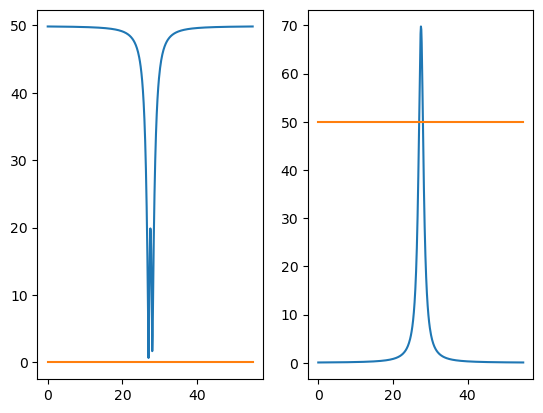

In [13]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


'''
Prelab code here
'''
print("\n\n\n\nPrelab")



# parameterize the setup

waist_at_laser = 0.1 #cm

len_before_telescope = 12.965  #inches

f_obj = 20  #cm
f_eye = 7.5   #cm

Roc   = 100  #cm

cav_big_arm   = 9   #inches
cav_small_arm = 3   #inches


#####################

print("\n\nabcd of cavity is:")
abcd_cav = abcd_cavity(cav_big_arm*2.54,cav_small_arm*2.54,Roc)
print(np.array(abcd_cav))


q_res = q_resonance_cavity(abcd_cav)
print("\nThe q_res of cavity is: "+ str(q_res))

w_cavity = calculate_waist_radius_from_q(q_res)[0]
print("waist cavity is: "+str(w_cavity*10)+" mm")


q0 = calculate_q(9999999999999999, waist_at_laser)
print("\n\nq0 is : "+str(1j*np.imag(q0))+"\n")
qin_telescope = calculate_q_out(1j*np.imag(q0),abcd_free_space(len_before_telescope*2.54))
print("qin_tel is : "+str(qin_telescope)+"\n")

#args_cavity = [f_obj,f_eye,qin_telescope,q_res]
args_cavity = [f_obj,f_eye,qin_telescope,q_res]

def function_telescope_len_for_cavity_with_args(x):
    return function_telescope_len_for_cavity(x, *args_cavity )


tel_len = scipy.optimize.fmin( function_telescope_len_for_cavity_with_args, 50)[0]

print("\n\nTelescope Length is : " + str(tel_len)+"\n\n")
x_val = np.arange(0,2*(f_obj+f_eye),0.1)
def y_0(x):
    return 0*x

subplot_lab2b_1 = plt.subplot(1,2,1)
subplot_lab2b_1.plot(x_val,function_telescope_len_for_cavity_with_args(x_val))
subplot_lab2b_1.plot(x_val,y_0(x_val))

#print(function_telescope_len_for_cavity_with_args(tel_len))
#abcd_tel = abcd_telescope(f_eye,f_obj,tel_len)
abcd_tel = abcd_telescope(f_eye,f_obj,tel_len)
print("abcd_tel is : \n" + str(np.array(abcd_tel)))
qout_tel = calculate_q_out(qin_telescope,abcd_tel)
print('qout_tel is :' + str(qout_tel)+"\n")
waist_tel = calculate_waist_radius_from_q(1j*np.imag(qout_tel))
print('waist_tel is :' + str(waist_tel[0]*10)+" mm\n")


def function_b_out_tel(x):
    _abcd = abcd_telescope(f_eye, f_obj, np.float64(x))
    _q_out = calculate_q_out(qin_telescope,_abcd)

    return np.imag(_q_out)

subplot_lab2b_2 = plt.subplot(1,2,2)
y3 = []
for x in x_val:
    y3.append(function_b_out_tel(x))
subplot_lab2b_2.plot(x_val,y3)
subplot_lab2b_2.plot(x_val,np.absolute(q_res)+0*x_val)

abcd_total = (np.array(abcd_free_space(np.absolute(np.real(qout_tel)))) @ np.array(abcd_tel) @ np.array(abcd_free_space(len_before_telescope)))
print(abcd_total)

#verification of abcd matrix, manually
abcd_temp = [[-0.263189, 126.216], [0.00353, 2.85324]]

print("q at the beginning of cavity is "+str(calculate_q_out(1j*np.imag(q0),abcd_total)))


In [7]:
print(len_before_telescope*2.54)
print(tel_len)
print(np.real(qout_tel))
print("total length of setup is "+str(len_before_telescope*2.54+tel_len-np.real(qout_tel)) + " cm")

32.9311
28.02999496459961
-39.0403816748454
total length of setup is 100.001476639445 cm
